In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge, ElasticNetCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot

from hyperopt import fmin, hp, tpe, Trials

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
train = pd.read_json('train_data.json.gz').set_index('vid_id', drop=True)
test = pd.read_json('test_data.json.gz').set_index('vid_id', drop=True)

In [3]:
train.columns

Index(['vid_caption', 'duration', 'width', 'height', 'fps', 'vcodec', 'vbr',
       'acodec', 'abr', 'thumb_width', 'thumb_height', 'pca_metric',
       'cnn_thumb_preds', 'vid_name_chars', 'vid_name_words', 'desc_chars',
       'desc_words', 'subtitle_chars', 'subtitle_words',
       'subtitle_words_unique', 'has_profanity', 'has_music', 'has_links',
       'link_perc', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'Education',
       'Entertainment', 'Film & Animation', 'Howto & Style', 'News & Politics',
       'People & Blogs', 'Travel & Events', 'other_category', 'num_tags',
       'num_emoji_in_tags'],
      dtype='object')

In [4]:
X_train, y_train = train.drop('pca_metric', axis=1), train['pca_metric']
X_test, y_test = test.drop('pca_metric', axis=1), test['pca_metric']

In [5]:
def plot_feature_importance(X, y):
    rf_mod = RandomForestRegressor(n_jobs=-1)
    rf_mod.fit(X, y)
    feature_importance = rf_mod.feature_importances_
    feats = pd.DataFrame(zip(X.columns, feature_importance), columns=['feature', 'importance'])
    feats = feats.sort_values('importance', ascending=False)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feats, color='lightblue', ax=ax)
    ax.set_title('Feature Importance')

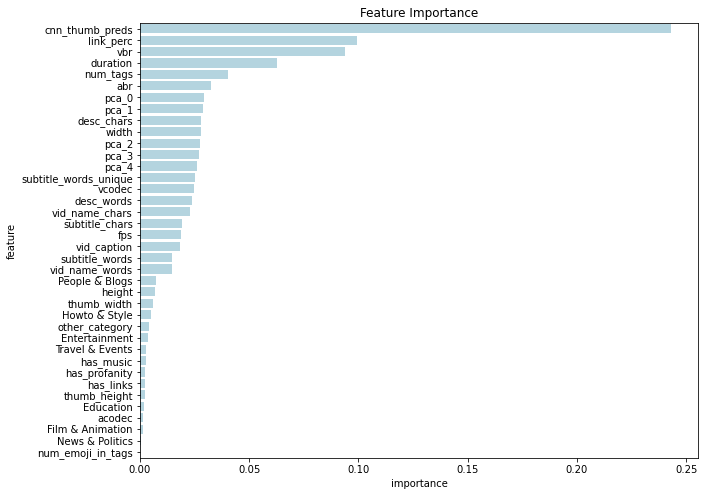

In [6]:
plot_feature_importance(X_train, y_train)

In [7]:
def score_model(model, X_train, y_train, folds:int=5, scoring:str='neg_root_mean_squared_error', 
                pipe_parts:list=[('scaler', StandardScaler()),]):
    
    if pipe_parts is not None:
        model = Pipeline(pipe_parts + [('model', model),])
    
    cv = KFold(n_splits=folds, shuffle=True)

    results = -cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

    return np.mean(results), np.std(results)

In [8]:
# untuned comparison
with_cnn_mean, with_cnn_std = score_model(LinearRegression(), X_train, y_train)
no_cnn_mean, np_cnn_std = score_model(LinearRegression(), X_train.drop('cnn_thumb_preds', axis=1), y_train)
print(f'With cnn feature    mean: {with_cnn_mean:.6f}, std: {with_cnn_std:.6f}')
print(f'Without cnn feature mean: {no_cnn_mean:.6f}, std: {np_cnn_std:.6f}')

With cnn feature    mean: 3.462154, std: 0.021646
Without cnn feature mean: 3.757671, std: 0.021143


In [9]:
# basian ridge
br_param_grid = {'alpha_1': hp.normal('alpha_1', 1e-6, 5e-6),
                 'alpha_2': hp.normal('alpha_2', 1e-6, 5e-6),
                 'lambda_1': hp.normal('lambda_1', 1e-6, 5e-6),
                 'lambda_2': hp.normal('lambda_2', 1e-6, 5e-6)}

def br_objective(search_space):
    alpha_1 = search_space['alpha_1']
    alpha_2 = search_space['alpha_2']
    lambda_1 = search_space['lambda_1']
    lambda_2 = search_space['lambda_2']
    
    br_model = BayesianRidge(alpha_1=alpha_1,
                              alpha_2=alpha_2,
                              lambda_1=lambda_1,
                              lambda_2=lambda_2)
    
    score, _ = score_model(br_model, X_train, y_train)
    
    return score
    

In [10]:
trials = Trials()
max_evals = 700
br_best_params = fmin(fn=br_objective, space=br_param_grid, algo=tpe.suggest, trials=trials, max_evals=max_evals)
br_best_params

100%|██████████| 700/700 [05:47<00:00,  2.01trial/s, best loss: 3.4610341505553235]


{'alpha_1': 1.1702365146637074e-06,
 'alpha_2': -2.0638811057885248e-07,
 'lambda_1': 8.645473293501741e-06,
 'lambda_2': -6.181439700502982e-06}

In [11]:
alpha_1 = br_best_params['alpha_1']
alpha_2 = br_best_params['alpha_2']
lambda_1 = br_best_params['lambda_1']
lambda_2 = br_best_params['lambda_2']

best_br_model = BayesianRidge(alpha_1=alpha_1,
                              alpha_2=alpha_2,
                              lambda_1=lambda_1,
                              lambda_2=lambda_2)

In [12]:
# LGBM

lgbm_param_grid = {'reg_alpha': hp.lognormal('reg_alpha', 0, .5),
                   'reg_lambda': hp.lognormal('reg_lambda', 0, .5),
                   'subsample': hp.uniform('subsample', 0, 1),
                   'num_leaves': hp.quniform('num_leaves', 10, 100, 1),
                   'max_depth': hp.quniform('max_depth', 1, 30, 1),
                   'n_estimators': hp.quniform('n_estimators', 50, 100, 1),
                   'learning_rate': hp.loguniform('learning_rate', -3, 0)}

def lgbm_objective(search_space):
    reg_alpha = search_space['reg_alpha']
    reg_lambda = search_space['reg_lambda']
    subsample = search_space['subsample']
    num_leaves = search_space['num_leaves']
    max_depth = search_space['max_depth']
    n_estimators = search_space['n_estimators']
    learning_rate = search_space['learning_rate']
    
    lgbm_model = LGBMRegressor(reg_alpha=reg_alpha,
                                reg_lambda=reg_lambda,
                                subsample=subsample,
                                num_leaves=int(num_leaves),
                                max_depth=int(max_depth),
                                n_estimators=int(n_estimators),
                                learning_rate=learning_rate,
                                n_jobs=-1)

    score, _ = score_model(lgbm_model, X_train, y_train)
    return score

In [13]:
trials = Trials()
max_evals = 1000
lgbm_best_params = fmin(fn=lgbm_objective, space=lgbm_param_grid, algo=tpe.suggest, trials=trials, max_evals=max_evals)
lgbm_best_params

100%|██████████| 1000/1000 [29:14<00:00,  1.75s/trial, best loss: 2.720532931824339]


{'learning_rate': 0.13886662226877997,
 'max_depth': 17.0,
 'n_estimators': 100.0,
 'num_leaves': 94.0,
 'reg_alpha': 3.3061725468197016,
 'reg_lambda': 0.30462466962261087,
 'subsample': 0.40436675298578373}

In [14]:
reg_alpha = lgbm_best_params['reg_alpha']
reg_lambda = lgbm_best_params['reg_lambda']
subsample = lgbm_best_params['subsample']
num_leaves = lgbm_best_params['num_leaves']
max_depth = lgbm_best_params['max_depth']
n_estimators = lgbm_best_params['n_estimators']
learning_rate = lgbm_best_params['learning_rate']

best_lgbm_model = LGBMRegressor(reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            subsample=subsample,
                            num_leaves=int(num_leaves),
                            max_depth=int(max_depth),
                            n_estimators=int(n_estimators),
                            learning_rate=learning_rate,
                            n_jobs=-1)

In [15]:
rf_param_grid = {'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
                 'max_depth': hp.quniform('max_depth', 2, 30, 1),
                 'max_features': hp.choice('max_features', ['auto', 'sqrt']),
                 'min_samples_split': hp.quniform('min_samples_split', 2, 5, 1),
                 'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1)}

def rf_objective(search_space):
    n_estimators = search_space['n_estimators']
    max_depth = search_space['max_depth']
    max_features = search_space['max_features']
    min_samples_split = search_space['min_samples_split']
    min_samples_leaf = search_space['min_samples_leaf']

    rf_model = RandomForestRegressor(n_estimators=int(n_estimators),
                                      max_depth=int(max_depth),
                                      max_features=max_features,
                                      min_samples_split=int(min_samples_split),
                                      min_samples_leaf=int(min_samples_leaf),
                                      n_jobs=-1)

    score, _ = score_model(rf_model, X_train, y_train)
    return score

In [16]:
trials = Trials()
max_evals = 200
rf_best_params = fmin(fn=rf_objective, space=rf_param_grid, algo=tpe.suggest, trials=trials, max_evals=max_evals)
rf_best_params

100%|██████████| 200/200 [31:53<00:00,  9.57s/trial, best loss: 2.746522178711868] 


{'max_depth': 27.0,
 'max_features': 1,
 'min_samples_leaf': 1.0,
 'min_samples_split': 2.0,
 'n_estimators': 468.0}

In [17]:
n_estimators = rf_best_params['n_estimators']
max_depth = rf_best_params['max_depth']
max_features = 'auto' if rf_best_params['max_features'] == 0 else 'sqrt'
min_samples_split = rf_best_params['min_samples_split']
min_samples_leaf = rf_best_params['min_samples_leaf']

best_rf_model = RandomForestRegressor(n_estimators=int(n_estimators),
                                    max_depth=int(max_depth),
                                    max_features=max_features,
                                    min_samples_split=int(min_samples_split),
                                    min_samples_leaf=int(min_samples_leaf),
                                    n_jobs=-1)

In [18]:
# adaboost
ada_param_grid = {'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
                  'max_depth': hp.quniform('max_depth', 1, 20, 1),
                  'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
                  'learning_rate': hp.lognormal('learning_rate', .01, .7),
                  'loss': hp.choice('loss', ['linear', 'square', 'exponential'])}

def ada_objective(search_space):
    n_estimators = search_space['n_estimators']
    max_depth = search_space['max_depth']
    min_samples_split = search_space['min_samples_split']
    learning_rate = search_space['learning_rate']
    loss = search_space['loss']

    ada_model = AdaBoostRegressor(n_estimators=int(n_estimators),
                                   learning_rate=learning_rate,
                                   loss=loss,
                                   base_estimator=DecisionTreeRegressor(max_depth=int(max_depth),
                                                                         min_samples_split=int(min_samples_split)))

    score, _ = score_model(ada_model, X_train, y_train)
    return score

In [19]:
trials = Trials()
max_evals = 50
ada_best_params = fmin(fn=ada_objective, space=ada_param_grid, algo=tpe.suggest, trials=trials, max_evals=max_evals)
ada_best_params

100%|██████████| 50/50 [42:22<00:00, 50.85s/trial, best loss: 2.694929426843263] 


{'learning_rate': 2.4750556547544087,
 'loss': 0,
 'max_depth': 19.0,
 'min_samples_split': 7.0,
 'n_estimators': 188.0}

In [20]:
n_estimators = ada_best_params['n_estimators']
max_depth = ada_best_params['max_depth']
min_samples_split = ada_best_params['min_samples_split']
learning_rate = ada_best_params['learning_rate']
loss = ['linear', 'square', 'exponential'][ada_best_params['loss']]

best_ada_model = AdaBoostRegressor(n_estimators=int(n_estimators),
                                    learning_rate=learning_rate,
                                    loss=loss,
                                    base_estimator=DecisionTreeRegressor(max_depth=int(max_depth),
                                                                        min_samples_split=int(min_samples_split)))

In [21]:
stacking_model = StackingRegressor(estimators=[('LGBMRegressor', best_lgbm_model),
                                               ('RandomForestRegressor', best_rf_model),
                                               ('AdaBoostRegressor', best_ada_model)],
                                               final_estimator=ElasticNetCV(),
                                               n_jobs=-1)

In [22]:
mean, std = score_model(stacking_model, X_train, y_train)
print(f'Stacking Model mean: {mean:.6f}, std: {std:.6f}')

Stacking Model mean: 2.653136, std: 0.023039


In [26]:
   
def resid_qq(y_test, predicted, ax):
    resids = y_test - predicted
    probplot(resids, plot=ax)
    ax.set_title('Q-Q normal plot')
    ax.set_ylabel('Sample Quantiles')
    ax.set_xlabel('Theoretical Quantiles')
    
def resid_plot(y_test, predictions, ax):
    resids = y_test - predictions
    sns.regplot(x=predictions, y=resids, ax=ax, fit_reg=False)
    ax.axhline(0, color='k')
    ax.set_title('Residuals vs. predicted values')
    ax.set_xlabel('Predicted values')
    ax.set_ylabel('Residuals')

def plot_er_hist(y_test, predicted, ax, bins=30):
    resids = y_test - predicted
    sns.distplot(resids, bins=bins, ax=ax)
    ax.set_title('Histogram of the Residuals')
    ax.set_xlabel("Residuals")
    
def final_test(mod, X_train, y_train, X_test, y_test):
    mod = Pipeline([('scaler', StandardScaler()), ('model', mod),])
    mod = clone(mod)
    mod.fit(X_train, y_train)
    preds = mod.predict(X_test)
    
    rmse = mean_squared_error(y_test, preds, squared=False)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle(f"{mod.named_steps['model'].__class__.__name__}\nRMSE: {rmse:1.6f}, MAE:{mae:1.6f} $r^2$:{r2:1.6f}", fontsize=18, y=1.1)
    resid_plot(y_test, preds, ax[0])
    plot_er_hist(y_test, preds, ax[1])
    resid_qq(y_test, preds, ax[2])
    plt.tight_layout()

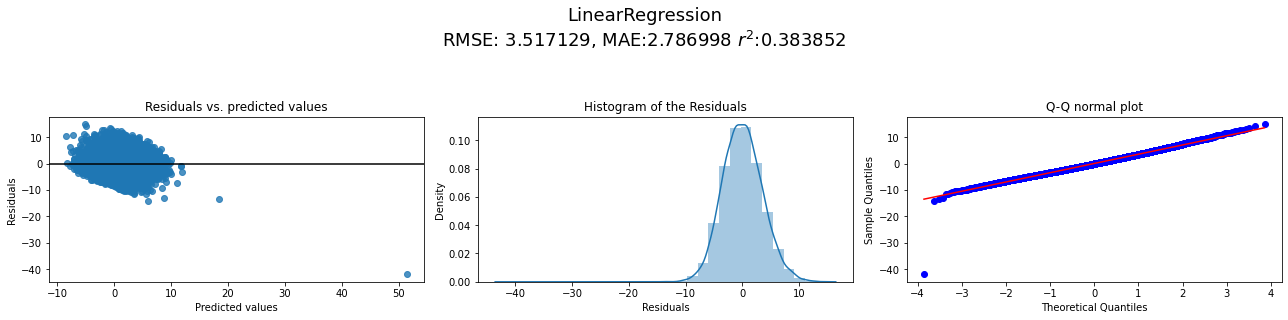

In [27]:
final_test(LinearRegression(), X_train, y_train, X_test, y_test)

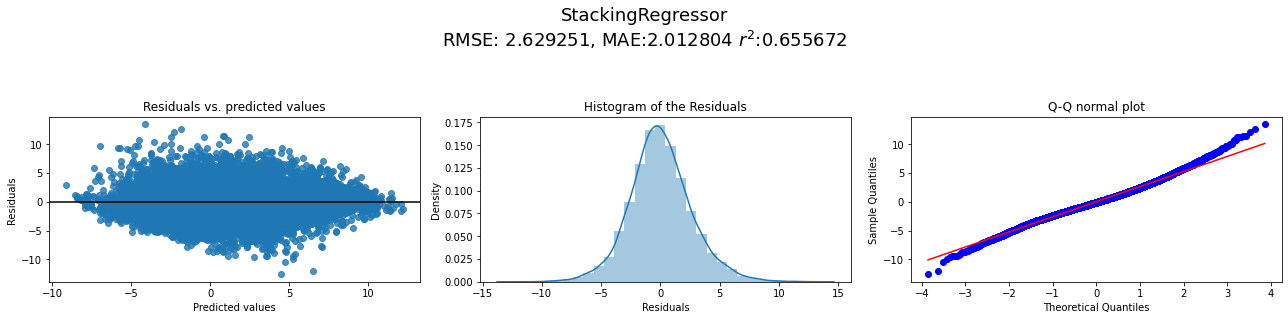

In [28]:
final_test(stacking_model, X_train, y_train, X_test, y_test)

In [29]:
import cloudpickle

stacking_model.fit(X_train, y_train)

cloudpickle.dump(stacking_model, open('trained_stacking_model.cloudpickle', 'wb'))